In [ ]:
"""

Date: May 2, 2022

Author: Karine Choquet

This script will make datasets and plots for Figures 6, S7 and S8 of the splicing order manuscript

"""

In [1]:
import numpy as np
import pandas as pd
import pysam
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")

import matplotlib.pyplot as plt
import re
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter

import math

import pybedtools
from pybedtools import BedTool

from collections import Counter

import random


import scipy
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr
from scipy.stats import chi2_contingency

import itertools

from statsmodels.stats.multitest import multipletests

from more_itertools import consecutive_groups

from tqdm import tqdm

## Co-occurrence of SE and RI

In [2]:
# Load annotations
gene_names_df = pd.read_table("/path/to/annotation_files/hg38_UCSC_refGene_names.txt", header=None)
gene_names_df.columns = ['gene_name', 'gene_id']

In [3]:
# Get intron features
hg38_intron_df = pd.read_table("/path/to/annotation_files/hg38_all_intron_features.txt")


In [4]:
# Import intron and exon splicing/inclusion statuses
U2_multi_introns_df = pd.read_table("/path/to/HeLa_U2_aso_polyA_RNA_hg38_multi_introns_isoforms_df_all.txt")
U2_multi_exons_df = pd.read_table("/path/to/HeLa_U2_aso_polyA_RNA_hg38_multi_exons_isoforms_df_all.txt")

# Merge intron and exon dataframes
U2_multi_both_df = U2_multi_introns_df.merge(U2_multi_exons_df, on=['read','gene','strand']).rename(columns={'splice_status_x':'splice_status_introns', 'splice_status_y':'splice_status_exons'})


In [5]:
# Import intron and exon splicing/inclusion statuses
ctrl_multi_introns_df = pd.read_table("/path/to/HeLa_ctrl_aso_polyA_RNA_hg38_multi_introns_isoforms_df_all.txt")
ctrl_multi_exons_df = pd.read_table("/path/to/HeLa_ctrl_aso_polyA_RNA_hg38_multi_exons_isoforms_df_all.txt")

# Merge intron and exon dataframes
ctrl_multi_both_df = ctrl_multi_introns_df.merge(ctrl_multi_exons_df, on=['read','gene','strand']).rename(columns={'splice_status_x':'splice_status_introns', 'splice_status_y':'splice_status_exons'})


In [6]:
# Merge with gene names
U2_multi_both_df['gene_id'] = U2_multi_both_df['gene'].str.split("\\.").str[0]
U2_multi_both_df = U2_multi_both_df.merge(gene_names_df, on='gene_id')

In [7]:
# Merge with gene names
ctrl_multi_both_df['gene_id'] = ctrl_multi_both_df['gene'].str.split("\\.").str[0]
ctrl_multi_both_df = ctrl_multi_both_df.merge(gene_names_df, on='gene_id')

In [8]:
# Combine intron and exon statuses from same reads
def combine_intron_exon_status(df, n_introns):
    
    results_list = []
    
    for row in range(len(df)):
        readname = df.loc[row]['read']
        strand = df.loc[row]['strand']
        intron_numbers = df.loc[row]['intron_numbers']
        exon_numbers = df.loc[row]['exon_numbers']
        splice_status_introns = df.loc[row]['splice_status_introns']
        splice_status_exons = df.loc[row]['splice_status_exons']
    
        intron_numbers_list = intron_numbers.split("_")
        exon_numbers_list = exon_numbers.split("_")
        splice_status_list_introns = splice_status_introns.split("_")
        splice_status_list_exons = splice_status_exons.split("_")
    
        new_splice_status_list = [readname]
    
        # Make dictionaries
        intron_dict = {}
        exon_dict = {}
    
        for i in range(len(intron_numbers_list)):
            intron_dict[int(intron_numbers_list[i])] = splice_status_list_introns[i]
        
        for i in range(len(exon_numbers_list)):
            exon_dict[int(exon_numbers_list[i])] = splice_status_list_exons[i]
        
        # Add the first intron
        if 0 in intron_dict.keys():
            if intron_dict[0] == "YES" or "SKP" in intron_dict[0]:
                new_splice_status_list.append(-1)
            elif intron_dict[0] == "NO":
                new_splice_status_list.append(-2)
            else:
                new_splice_status_list.append(0)
        else:
            new_splice_status_list.append(0)
        
        # Then loop through the other exons and introns
        for k in range(1,n_introns):
            # exon (except first and last)
            
            if k in exon_dict.keys():
                if exon_dict[k] == 'INCL':
                    new_splice_status_list.append(-2)
                elif exon_dict[k] == 'EXCL':
                    new_splice_status_list.append(-1)
                else:
                    new_splice_status_list.append(0)
            else:
                new_splice_status_list.append(0)
            
            # intron
            if k in intron_dict.keys():
                if intron_dict[k] == "YES" or "SKP" in intron_dict[k]:
                    new_splice_status_list.append(-1)
                elif intron_dict[k] == "NO":
                    new_splice_status_list.append(-2)
                else:
                    new_splice_status_list.append(0)
            else:
                new_splice_status_list.append(0)
            
            
        results_list.append(new_splice_status_list)
        results_df = pd.DataFrame(results_list)
            
    return(results_df)
            
    
    

In [9]:
# Make a matrix where each read is a row and each intron/exon is a column
U2_RAN_df = U2_multi_both_df[U2_multi_both_df['gene_id']=='NM_006325'].reset_index(drop=True)

U2_RAN_mat = combine_intron_exon_status(U2_RAN_df, 6)
U2_RAN_mat.index = U2_RAN_mat[0]
U2_RAN_mat = U2_RAN_mat.drop([0],axis=1)
U2_RAN_mat

,1,2,3,4,5,6,7,8,9,10,11
0,,,,,,,,,,,
91300ed9-71e0-414d-aad8-32f9ce40ab70,-1,-1,-1,-2,-1,-2,-1,-2,-1,-2,-1
217e4789-1484-4f23-96f8-15f11c8eb926,-1,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1
10dd4d98-7a90-4d21-9107-df0bda6bec5c,-1,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1
90290aef-d79d-45c2-9391-44ce2da2fc28,-1,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1
4cc13e5e-8adb-45e9-a5b2-ad3545f93140,-1,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1
...,...,...,...,...,...,...,...,...,...,...,...
a66e2a0f-d8da-498c-85c8-78d33ced5e6f,0,0,0,0,0,0,0,0,-1,-2,-1
108ddebb-4a22-4926-ab64-0c17c3c52ecf,0,0,0,0,0,0,0,0,-2,-2,-1
859020ef-5d8d-48aa-8e34-6d4147433c8f,0,0,0,0,0,0,0,0,-2,-2,-2


In [10]:
ctrl_RAN_df = ctrl_multi_both_df[ctrl_multi_both_df['gene_id']=='NM_006325'].reset_index(drop=True)

ctrl_RAN_mat = combine_intron_exon_status(ctrl_RAN_df, 6)
ctrl_RAN_mat.index = ctrl_RAN_mat[0]
ctrl_RAN_mat = ctrl_RAN_mat.drop([0],axis=1)
ctrl_RAN_mat

,1,2,3,4,5,6,7,8,9,10,11
0,,,,,,,,,,,
9efc03da-b955-4a5c-84f1-db7bdd26f7af,-1,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1
5e9b1a0e-21fc-489f-94ae-4af601781ade,-1,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1
621d4ac8-8cbf-441f-99e4-06cd3aa027b1,-1,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1
a8340e62-8609-4937-939f-54f3ce75745c,-1,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1
0bdb610e-b2dd-4294-b882-540adb30d598,-1,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1
...,...,...,...,...,...,...,...,...,...,...,...
ae53f5c9-a28e-4b7d-a816-c67f8a3d46ab,0,0,0,0,0,0,0,0,-2,-2,-2
26bbf195-0ce3-46c9-97d0-1589b8306ff6,0,0,0,0,0,0,0,0,-1,-2,-1
a8cd3d14-0430-4fa3-b4f4-7515ba55f42a,0,0,0,0,0,0,0,0,-2,-2,-1


/Users/karinechoquet/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


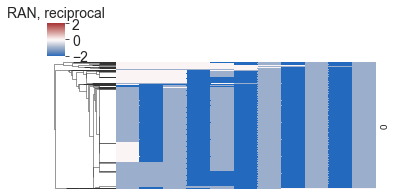

In [11]:
gene_name = "RAN"
SE_RI = "reciprocal"

sns.clustermap(U2_RAN_mat, col_cluster=False, cmap="vlag", 
               yticklabels=False, xticklabels=False, figsize=(5,2.5),
               vmin=-2, vmax=2)

plt.title(gene_name + ', ' + SE_RI, fontsize=14)

plt.savefig("/path/to/plots/Fig5_RAN_SE_RI_heatmap_U2_kd.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.show()

/Users/karinechoquet/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


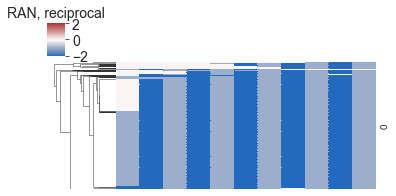

In [12]:
gene_name = "RAN"
SE_RI = "reciprocal"

sns.clustermap(ctrl_RAN_mat, col_cluster=False, cmap="vlag", 
               yticklabels=False, xticklabels=False, figsize=(5,2.5),
               vmin=-2, vmax=2)

plt.title(gene_name + ', ' + SE_RI, fontsize=14)

plt.savefig("/path/to/plots/Fig5_RAN_SE_RI_heatmap_ctrl_kd.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [13]:
U2_IFRD2_df = U2_multi_both_df[U2_multi_both_df['gene_id']=='NM_006764'].reset_index(drop=True)

U2_IFRD2_mat = combine_intron_exon_status(U2_IFRD2_df, 11)
U2_IFRD2_mat.index = U2_IFRD2_mat[0]
U2_IFRD2_mat = U2_IFRD2_mat.drop([0],axis=1)
U2_IFRD2_mat

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,,,,,,,,,,,,,,,,,,,,,
1cafd8bf-1c6f-41e1-93d6-f22cc6d25a8b,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1ac1cc17-c82f-42e5-a600-ee0636632750,-1,-2,-1,-2,-1,-2,-1,-2,-1,-2,...,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1
1cd81f38-154d-4a51-be31-f3d7b2834a22,-1,-2,-1,-2,-1,-2,-1,-2,-1,-2,...,-2,-1,-2,-1,-2,-1,-2,-2,-2,-1
2839fb1a-c5c8-4841-b05c-790c7aa2729e,-2,-2,-2,-2,-2,-2,-1,-1,-1,-1,...,-2,-1,-2,-2,-2,-2,-2,0,0,0
6f893099-745d-4e9a-b1b3-0bb226ed4773,-1,-2,-1,-2,-1,-2,-1,-2,-1,-2,...,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0b9a471f-1590-426c-96ad-6bf54920fd29,0,0,0,0,0,0,0,-2,-1,-2,...,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1
66509878-7469-472f-8286-3888abbdbfc2,0,0,0,0,0,0,0,-2,-1,-2,...,-2,-1,-2,-1,0,0,0,0,0,0
f02f492c-74ad-4a6e-95f2-e9e4ae67f0fe,0,0,0,0,0,0,0,0,0,-2,...,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1


In [14]:
ctrl_IFRD2_df = ctrl_multi_both_df[ctrl_multi_both_df['gene_id']=='NM_006764'].reset_index(drop=True)

ctrl_IFRD2_mat = combine_intron_exon_status(ctrl_IFRD2_df, 11)
ctrl_IFRD2_mat.index = ctrl_IFRD2_mat[0]
ctrl_IFRD2_mat = ctrl_IFRD2_mat.drop([0],axis=1)
ctrl_IFRD2_mat

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,,,,,,,,,,,,,,,,,,,,,
a2af87c5-cd5c-4183-9668-94c5b68b12d7,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
6b1100b3-a1fa-4c58-81c3-44db36236145,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
cb9fac86-87c4-4f94-869b-e24c131fa835,-1,-2,-1,-2,-1,-2,-1,-1,-1,-1,...,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1
0ca7fb55-0f49-4c45-9fab-5fa817e5d4e8,-1,-2,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93c1b77d-fe1b-4293-a8d0-e362974acc60,-1,-2,-1,-2,-1,-2,-1,-2,-1,-2,...,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4643f2bd-5ee4-483b-b46d-0aefbb6ed8db,0,0,0,0,0,0,0,0,0,-2,...,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1
c8eb3b9d-aab8-4ce6-ac12-1dea3d84f87f,0,0,0,0,0,0,0,0,0,0,...,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1
2c6acbb3-e634-41d9-a9a2-e794cd7dc25b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-1,-2,-1,-2,-1,-2,-1


/Users/karinechoquet/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


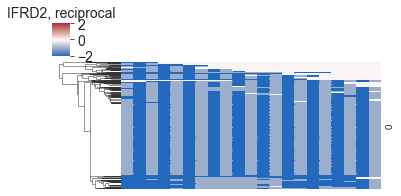

In [15]:
gene_name = "IFRD2"
SE_RI = "reciprocal"

sns.clustermap(U2_IFRD2_mat, col_cluster=False, cmap="vlag", 
               yticklabels=False, xticklabels=False, figsize=(5,2.5),
               vmin=-2, vmax=2)

plt.title(gene_name + ', ' + SE_RI, fontsize=14)

plt.savefig("/path/to/plots/Fig5_IFRD2_SE_RI_heatmap_U2_kd.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.show()

/Users/karinechoquet/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


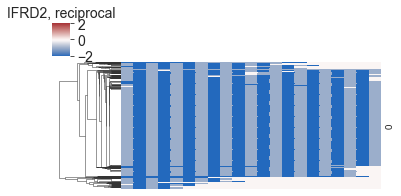

In [16]:
gene_name = "IFRD2"
SE_RI = "reciprocal"

sns.clustermap(ctrl_IFRD2_mat, col_cluster=False, cmap="vlag", 
               yticklabels=False, xticklabels=False, figsize=(5,2.5),
               vmin=-2, vmax=2)

plt.title(gene_name + ', ' + SE_RI, fontsize=14)

plt.savefig("/path/to/plots/Fig5_IFRD2_SE_RI_heatmap_ctrl_kd.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.show()

## Binomial test results for SE/RI co-occurrence

In [17]:
# Gene annotations
gene_names_df = pd.read_table("/path/to/annotation_files/hg38_UCSC_refGene_names.txt", header=None)
gene_names_df.columns = ['gene_name', 'gene']

In [18]:
# Load read counts per splicing status computed on O2
binom_df = pd.read_table("/path/to/HeLa_ctrl_vs_U2_intron_exon_pair_splice_status.txt")


In [19]:
# Add gene name
binom_df['gene'] = binom_df['pair_id'].str.split("\\.").str[0]
binom_df = binom_df.merge(gene_names_df, on='gene')

In [20]:
# Perform binominal test using alternative hypothesis that takes into account the level of RI or SE
binom_test2 = binom_df.copy()[['gene_name','pair_id','count_U2','NO_INCL_U2','YES_EXCL_U2','YES_INCL_U2','count_ctrl','NO_INCL_ctrl','YES_EXCL_ctrl','YES_INCL_ctrl']]

binom_test2['total_counts_U2'] = binom_test2['NO_INCL_U2'] + binom_test2['count_U2'] + binom_test2['YES_EXCL_U2'] + binom_test2['YES_INCL_U2']
binom_test2['freq_RI_U2'] = (binom_test2['NO_INCL_U2']+binom_test2['count_U2']) / binom_test2['total_counts_U2']
binom_test2['freq_SE_U2'] = (binom_test2['YES_EXCL_U2']+binom_test2['count_U2']) / binom_test2['total_counts_U2']
binom_test2['freq_SE_RI_U2'] = (binom_test2['count_U2']) / binom_test2['total_counts_U2']
binom_test2['freq_SE_giv_RI_U2'] = binom_test2['freq_SE_RI_U2'] / binom_test2['freq_RI_U2']
binom_test2['freq_RI_giv_SE_U2'] = binom_test2['freq_SE_RI_U2'] / binom_test2['freq_SE_U2']


binom_test2['total_counts_ctrl'] = binom_test2['NO_INCL_ctrl'] + binom_test2['count_ctrl'] + binom_test2['YES_EXCL_ctrl'] + binom_test2['YES_INCL_ctrl']
binom_test2['freq_RI_ctrl'] = (binom_test2['NO_INCL_ctrl']+binom_test2['count_ctrl']) / binom_test2['total_counts_ctrl']
binom_test2['freq_SE_ctrl'] = (binom_test2['YES_EXCL_ctrl']+binom_test2['count_ctrl']) / binom_test2['total_counts_ctrl']
binom_test2['freq_SE_RI_ctrl'] = (binom_test2['count_ctrl']) / binom_test2['total_counts_ctrl']
binom_test2['freq_SE_giv_RI_ctrl'] = binom_test2['freq_SE_RI_ctrl'] / binom_test2['freq_RI_ctrl']
binom_test2['freq_RI_giv_SE_ctrl'] = binom_test2['freq_SE_RI_ctrl'] / binom_test2['freq_SE_ctrl']


binom_test2['pvalue_SEgivRI_U2'] = binom_test2.apply(lambda row: scipy.stats.binom_test([row.count_U2, row.NO_INCL_U2], p=row.freq_SE_U2, alternative='greater'), axis=1)
binom_test2['pvalue_RIgivSE_U2'] = binom_test2.apply(lambda row: scipy.stats.binom_test([row.count_U2, row.YES_EXCL_U2], p=row.freq_RI_U2, alternative='greater'), axis=1)
binom_test2['pvalue_SEgivRI_ctrl'] = binom_test2.apply(lambda row: scipy.stats.binom_test([row.count_ctrl, row.NO_INCL_ctrl], p=row.freq_SE_ctrl, alternative='greater'), axis=1)
binom_test2['pvalue_RIgivSE_ctrl'] = binom_test2.apply(lambda row: scipy.stats.binom_test([row.count_ctrl, row.YES_EXCL_ctrl], p=row.freq_RI_ctrl, alternative='greater'), axis=1)

binom_test2['FDR_SEgivRI_U2'] = multipletests(binom_test2['pvalue_SEgivRI_U2'].astype(float), alpha=0.05, method='fdr_bh')[1]
binom_test2['FDR_RIgivSE_U2'] = multipletests(binom_test2['pvalue_RIgivSE_U2'].astype(float), alpha=0.05, method='fdr_bh')[1]
binom_test2['FDR_SEgivRI_ctrl'] = multipletests(binom_test2['pvalue_SEgivRI_ctrl'].astype(float), alpha=0.05, method='fdr_bh')[1]
binom_test2['FDR_RIgivSE_ctrl'] = multipletests(binom_test2['pvalue_RIgivSE_ctrl'].astype(float), alpha=0.05, method='fdr_bh')[1]

In [21]:
# Add a category for SE_RI to each sample
binom_test2['category_U2'] = "non-sig"
binom_test2.loc[(binom_test2['FDR_RIgivSE_U2']<0.05) & (binom_test2['FDR_SEgivRI_U2']<0.05),'category_U2'] = 'reciprocal'
binom_test2.loc[(binom_test2['FDR_RIgivSE_U2']>=0.05) & (binom_test2['FDR_SEgivRI_U2']<0.05),'category_U2'] = 'SE|RI'
binom_test2.loc[(binom_test2['FDR_SEgivRI_U2']>=0.05) & (binom_test2['FDR_RIgivSE_U2']<0.05),'category_U2'] = 'RI|SE'

binom_test2['category_ctrl'] = "non-sig"
binom_test2.loc[(binom_test2['FDR_RIgivSE_ctrl']<0.05) & (binom_test2['FDR_SEgivRI_ctrl']<0.05),'category_ctrl'] = 'reciprocal'
binom_test2.loc[(binom_test2['FDR_RIgivSE_ctrl']>=0.05) & (binom_test2['FDR_SEgivRI_ctrl']<0.05),'category_ctrl'] = 'SE|RI'
binom_test2.loc[(binom_test2['FDR_SEgivRI_ctrl']>=0.05) & (binom_test2['FDR_RIgivSE_ctrl']<0.05),'category_ctrl'] = 'RI|SE'



In [25]:
# Write to file for further plotting in R
binom_test2.to_csv("/path/to/DirectRNA_SE_RI_analysis_revisited.txt", sep="\t", header=True, index=False)



In [26]:
# Rename columns to be clearer for Supp Table
binom_test2_for_supp = binom_test2.rename(columns={'count_U2':'NO_EXCL_U2','count_ctrl':'NO_EXCL_ctrl'})
binom_test2_for_supp.to_csv("/path/to/Table_S8_SE_RI.txt", sep="\t", header=True, index=False)

## Splicing order and SE/RI

In [28]:
# Extract introns of interest for splicing order analyses
binom_test2_sig = binom_test2[binom_test2['category_U2']=='reciprocal'].reset_index(drop=True)

intron_df = binom_test2_sig.copy()[['gene_name','pair_id']]
intron_df['gene'] = intron_df['pair_id'].str.split(",").str[0]
intron_df['intron'] = intron_df['pair_id'].str.split(",").str[1].astype(int)
intron_df['exon1'] = intron_df['pair_id'].str.split(",").str[2].astype(int) - 1
intron_df['exon2'] = intron_df['pair_id'].str.split(",").str[2].astype(int)

# Get intron annotations
hg38_intron_df = pd.read_table("/path/to/annotation_files/hg38_all_intron_features.txt")
hg38_intron_totals = hg38_intron_df.copy()[['gene','strand','intron_total']]

intron_df = intron_df.merge(hg38_intron_totals, on='gene')

In [30]:
# Define intron groups composed of the RI intron and the two introns flanking the SE
def define_triplets(intron, exon1, exon2, strand, intron_total):
    
    my_list = [intron, exon1, exon2]
    my_list.sort()
    
    my_list_join = "_".join([str(a) for a in my_list])

    if strand == "+":
        my_new_list = [int(a) + 1 for a in my_list]
        my_new_list_join = "_".join([str(a) for a in my_new_list])
        
    if strand == "-":
        my_new_list = [intron_total - a for a in my_list]
        my_new_list_join = "_".join([str(a) for a in my_new_list])
    
    return(my_list_join, my_new_list_join)

In [31]:
# Define triplet using intron numbers based on genomic coordinates, and then using intron numbers in transcript
intron_df['triplet'] = intron_df.apply(lambda row: define_triplets(row.intron, row.exon1, row.exon2, row.strand, row.intron_total)[0], axis=1)
intron_df['triplet2'] = intron_df.apply(lambda row: define_triplets(row.intron, row.exon1, row.exon2, row.strand, row.intron_total)[1], axis=1)


intron_df_sub = intron_df.copy()[['gene','triplet']].drop_duplicates().reset_index(drop=True)
intron_df_sub.to_csv("/path/to/PromethION_SE_RI_triplets_for_splicing_order_analyses.txt", sep="\t", header=True, index=False)
intron_df.to_csv("/path/to/PromethION_SE_RI_triplets_for_splicing_order_analyses.more_info.txt", sep="\t", header=True, index=False)



## U2 mutant mouse

In [38]:
# Gene names for mouse
gene_names_df = pd.read_table("/path/to/NCBI_RefSeq_mm10_gene_names.txt")
gene_names_df.columns = ['gene','gene_name']

In [39]:
# SE/RI results from cluster
binom_df = pd.read_table("/path/to/WT_vs_Mu_co_occurrence_tests.from_SE_list.SE_RI_all_genes.txt")
binom_df['gene'] = binom_df['pair_id'].str.split(",").str[0]
binom_df = binom_df.merge(gene_names_df, on=['gene'])

In [40]:
# Perform binominal test using alternative hypothesis that takes into account the level of RI or SE
binom_test2 = binom_df.copy()[['gene_name','pair_id','count_Mu','NO_INCL_Mu','YES_EXCL_Mu','YES_INCL_Mu','count_WT','NO_INCL_WT','YES_EXCL_WT','YES_INCL_WT']]

binom_test2['total_counts_Mu'] = binom_test2['NO_INCL_Mu'] + binom_test2['count_Mu'] + binom_test2['YES_EXCL_Mu'] + binom_test2['YES_INCL_Mu']
binom_test2['freq_RI_Mu'] = (binom_test2['NO_INCL_Mu']+binom_test2['count_Mu']) / binom_test2['total_counts_Mu']
binom_test2['freq_SE_Mu'] = (binom_test2['YES_EXCL_Mu']+binom_test2['count_Mu']) / binom_test2['total_counts_Mu']

binom_test2['total_counts_WT'] = binom_test2['NO_INCL_WT'] + binom_test2['count_WT'] + binom_test2['YES_EXCL_WT'] + binom_test2['YES_INCL_WT']
binom_test2['freq_RI_WT'] = (binom_test2['NO_INCL_WT']+binom_test2['count_WT']) / binom_test2['total_counts_WT']
binom_test2['freq_SE_WT'] = (binom_test2['YES_EXCL_WT']+binom_test2['count_WT']) / binom_test2['total_counts_WT']


binom_test2['pvalue_SEgivRI_Mu'] = binom_test2.apply(lambda row: scipy.stats.binom_test([row.count_Mu, row.NO_INCL_Mu], p=row.freq_SE_Mu, alternative='greater'), axis=1)
binom_test2['pvalue_RIgivSE_Mu'] = binom_test2.apply(lambda row: scipy.stats.binom_test([row.count_Mu, row.YES_EXCL_Mu], p=row.freq_RI_Mu, alternative='greater'), axis=1)
binom_test2['pvalue_SEgivRI_WT'] = binom_test2.apply(lambda row: scipy.stats.binom_test([row.count_WT, row.NO_INCL_WT], p=row.freq_SE_WT, alternative='greater'), axis=1)
binom_test2['pvalue_RIgivSE_WT'] = binom_test2.apply(lambda row: scipy.stats.binom_test([row.count_WT, row.YES_EXCL_WT], p=row.freq_RI_WT, alternative='greater'), axis=1)

binom_test2['FDR_SEgivRI_Mu'] = multipletests(binom_test2['pvalue_SEgivRI_Mu'].astype(float), alpha=0.05, method='fdr_bh')[1]
binom_test2['FDR_RIgivSE_Mu'] = multipletests(binom_test2['pvalue_RIgivSE_Mu'].astype(float), alpha=0.05, method='fdr_bh')[1]
binom_test2['FDR_SEgivRI_WT'] = multipletests(binom_test2['pvalue_SEgivRI_WT'].astype(float), alpha=0.05, method='fdr_bh')[1]
binom_test2['FDR_RIgivSE_WT'] = multipletests(binom_test2['pvalue_RIgivSE_WT'].astype(float), alpha=0.05, method='fdr_bh')[1]

In [41]:
# Add a category for SE_RI
binom_test2['category_Mu'] = "non-sig"
binom_test2.loc[(binom_test2['FDR_RIgivSE_Mu']<0.05) & (binom_test2['FDR_SEgivRI_Mu']<0.05),'category_Mu'] = 'reciprocal'
binom_test2.loc[(binom_test2['FDR_RIgivSE_Mu']>=0.05) & (binom_test2['FDR_SEgivRI_Mu']<0.05),'category_Mu'] = 'SE|RI'
binom_test2.loc[(binom_test2['FDR_SEgivRI_Mu']>=0.05) & (binom_test2['FDR_RIgivSE_Mu']<0.05),'category_Mu'] = 'RI|SE'

# Add a category for SE_RI
binom_test2['category_WT'] = "non-sig"
binom_test2.loc[(binom_test2['FDR_RIgivSE_WT']<0.05) & (binom_test2['FDR_SEgivRI_WT']<0.05),'category_WT'] = 'reciprocal'
binom_test2.loc[(binom_test2['FDR_RIgivSE_WT']>=0.05) & (binom_test2['FDR_SEgivRI_WT']<0.05),'category_WT'] = 'SE|RI'
binom_test2.loc[(binom_test2['FDR_SEgivRI_WT']>=0.05) & (binom_test2['FDR_RIgivSE_WT']<0.05),'category_WT'] = 'RI|SE'



In [42]:
# Write to file for further plotting in R
binom_test2.to_csv("/path/to/DirectRNA_SE_RI_analysis_revisited_mouse.txt", sep="\t", header=True, index=False)

In [43]:
# Get frequencies for an example gene
def get_SE_RI_freq_per_gene_mouse(df, gene_name, pair_id):
    # Make a plot example of binomial test with RAN for RI given SE

    # A: RI
    # B: SE
    
    my_dict = {}

    plot_df = df[df['pair_id']==pair_id].reset_index(drop=True)

    count_A = float(plot_df['NO_INCL_Mu'])
    count_B = float(plot_df['YES_EXCL_Mu'])
    count_AB = float(plot_df['count_Mu'])
    count_total = float(plot_df['total_counts_Mu'])


    freq_A = (count_A + count_AB) / count_total
    freq_B = (count_B + count_AB) / count_total
    freq_AB = count_AB / count_total

    freq_A_giv_B = freq_AB / freq_B # (according to Bayes' theorem)
    
    freq_B_giv_A = freq_AB / freq_A
    
    my_dict['freq_RI'] = freq_A
    my_dict['freq_SE'] = freq_B
    my_dict['freq_RI_giv_SE'] = freq_A_giv_B
    my_dict['freq_SE_giv_RI'] = freq_B_giv_A
    
    my_df = pd.DataFrame.from_dict(my_dict, orient='index').reset_index()
    my_df.columns = ['frequency', 'value']
    my_df['category'] = ['RI|SE', 'SE|RI', 'RI|SE', 'SE|RI']

    return my_df

In [44]:
# Apply function above to an intron/exon pair in Puf60
Puf60_df_for_plot = get_SE_RI_freq_per_gene_mouse(binom_test2, 'Puf60', 'NM_133691.5,5,3')
Puf60_df_for_plot.to_csv("/path/to/Figure_S7_Puf60_frequencies_mouse.txt", sep="\t", header=True, index=False)


## Splicing order heatmaps for IFRD2

In [45]:
# Get splicing status for introns within intron group only
def code_intron_status(df, n_introns):
    
    results_list = []
    
    for row in range(len(df)):
        readname = df.loc[row]['read']
        strand = df.loc[row]['strand']
        intron_numbers = df.loc[row]['intron_numbers']
        splice_status_introns = df.loc[row]['splice_status']
    
        intron_numbers_list = intron_numbers.split("_")
        splice_status_list_introns = splice_status_introns.split("_")
    
        new_splice_status_list = [readname]
    
        # Make dictionaries
        intron_dict = {}
    
        for i in range(len(intron_numbers_list)):
            intron_dict[int(intron_numbers_list[i])] = splice_status_list_introns[i]
        
        # Loop through the introns
        for k in range(0,n_introns):
            if k in intron_dict.keys():
                if intron_dict[k] == "YES" or "SKP" in intron_dict[k]:
                    new_splice_status_list.append(-1)
                elif intron_dict[k] == "NO":
                    new_splice_status_list.append(-2)
                else:
                    new_splice_status_list.append(0)
            else:
                new_splice_status_list.append(0)
                        
            
        results_list.append(new_splice_status_list)
        results_df = pd.DataFrame(results_list)
            
    return(results_df)
            
    
    

In [46]:
# Get color based on splicing level (number of excised introns)
def get_color(sum_spliced, total_introns):
    
    min_sum = total_introns * -2
    
    if sum_spliced == min_sum:
        color = sns.color_palette("Dark2")[0]
    elif sum_spliced == min_sum +1:
        color = sns.color_palette("Dark2")[1]
    elif sum_spliced == min_sum +2:
        color = sns.color_palette("Dark2")[2]
    elif sum_spliced == min_sum +3:
        color = sns.color_palette("Dark2")[3]
    elif sum_spliced == min_sum +4:
        color = sns.color_palette("Dark2")[4]
    elif sum_spliced == min_sum +5:
        color = sns.color_palette("Dark2")[5]
    else:
        color = sns.color_palette("Dark2")[7]
        
    return color
        

In [47]:
# Load intron features and gene_names df
hg38_intron_df = pd.read_table("/path/to/hg38_all_intron_features.txt")
gene_names_df = pd.read_table("/path/to/hg38_UCSC_refGene_names.txt")
gene_names_df.columns = ['gene_name','gene_id']

hg38_intron_df['gene_id'] = hg38_intron_df['gene'].str.split("\\.").str[0]

hg38_intron_df = hg38_intron_df.merge(gene_names_df, on='gene_id')

hg38_intron_coord = hg38_intron_df.copy()[['chrom','start','end','gene','intron_pos']]


In [48]:
# Import data
ctrl_1_multi_introns_df = pd.read_table("/path/to/HeLa_ASO_chrRNA_barcode01_ctrl_kd_1_hg38_multi_introns_df.txt")
U2_1_multi_introns_df = pd.read_table("/path/to/HeLa_ASO_chrRNA_barcode02_U2_kd_1_hg38_multi_introns_df.txt")

In [49]:
# Select reads that map completely to the intron group and that are intermediate isoforms
ctrl_1_reads_IFRD2 = ctrl_1_multi_introns_df[(ctrl_1_multi_introns_df['gene'].str.startswith("NM_006764")) &
                                      (ctrl_1_multi_introns_df['intron_numbers']=='7_6_5_4_3_2') &
                                      (ctrl_1_multi_introns_df['splice_status'].str.contains("NO")) &
                                      ((ctrl_1_multi_introns_df['splice_status'].str.contains("YES")) | (ctrl_1_multi_introns_df['splice_status'].str.contains("SKP"))) &
                                      (~ctrl_1_multi_introns_df['splice_status'].str.contains("UND"))].reset_index(drop=True)
# Compute splicing level
ctrl_1_reads_IFRD2['level'] = ctrl_1_reads_IFRD2['splice_status'].str.count(r'NO')

# Repeat for U2
U2_1_reads_IFRD2 = U2_1_multi_introns_df[(U2_1_multi_introns_df['gene'].str.startswith("NM_006764")) &
                                      (U2_1_multi_introns_df['intron_numbers']=='7_6_5_4_3_2') &
                                      (U2_1_multi_introns_df['splice_status'].str.contains("NO")) &
                                      ((U2_1_multi_introns_df['splice_status'].str.contains("YES")) | (U2_1_multi_introns_df['splice_status'].str.contains("SKP"))) &
                                      (~U2_1_multi_introns_df['splice_status'].str.contains("UND"))].reset_index(drop=True)

U2_1_reads_IFRD2['level'] = U2_1_reads_IFRD2['splice_status'].str.count(r'NO')

In [50]:
# Randomly sample rows to get 100 reads per splicing level
ctrl_1_sub_reads_IFRD2 = ctrl_1_reads_IFRD2.groupby('level').sample(100, replace=False).reset_index(drop=True)
U2_1_sub_reads_IFRD2 = U2_1_reads_IFRD2.groupby('level').sample(100, replace=False).reset_index(drop=True)

In [51]:
# Make matrix for plotting heatmap
IFRD2_ctrl_mat1 = code_intron_status(ctrl_1_sub_reads_IFRD2, 10)
IFRD2_ctrl_mat1.index = IFRD2_ctrl_mat1[0]
IFRD2_ctrl_mat1 = IFRD2_ctrl_mat1[[8,7,6,5,4,3]]

IFRD2_ctrl_mat1['sum_spliced'] = IFRD2_ctrl_mat1.sum(axis=1)
IFRD2_ctrl_mat1['level'] = IFRD2_ctrl_mat1.apply(lambda row: get_color(row.sum_spliced, 6), axis=1)


IFRD2_ctrl_colors1 = IFRD2_ctrl_mat1['level']

IFRD2_ctrl_mat1_bis = IFRD2_ctrl_mat1.sort_values(by=['sum_spliced',8,7,6,5,4,3])
IFRD2_ctrl_mat1_bis = IFRD2_ctrl_mat1_bis.drop(columns=['sum_spliced','level'])


In [52]:
# Make matrix for plotting heatmap
IFRD2_U2_mat1 = code_intron_status(U2_1_sub_reads_IFRD2, 10)
IFRD2_U2_mat1.index = IFRD2_U2_mat1[0]
IFRD2_U2_mat1 = IFRD2_U2_mat1[[8,7,6,5,4,3]]

IFRD2_U2_mat1['sum_spliced'] = IFRD2_U2_mat1.sum(axis=1)
IFRD2_U2_mat1['level'] = IFRD2_U2_mat1.apply(lambda row: get_color(row.sum_spliced, 6), axis=1)


IFRD2_U2_colors1 = IFRD2_U2_mat1['level']

IFRD2_U2_mat1_bis = IFRD2_U2_mat1.sort_values(by=['sum_spliced',8,7,6,5,4,3])
IFRD2_U2_mat1_bis = IFRD2_U2_mat1_bis.drop(columns=['sum_spliced','level'])


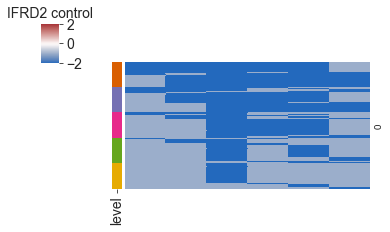

In [53]:
gene_name = "IFRD2"
replicate = "control"

sns.clustermap(IFRD2_ctrl_mat1_bis, col_cluster=False, row_cluster=False, 
               cmap="vlag", yticklabels=False, xticklabels=False, figsize=(5,3),
              row_colors=IFRD2_ctrl_colors1, vmin=-2, vmax=2)

plt.title(gene_name + ' ' + replicate, fontsize=14)

plt.savefig("/path/to/plots/FigS8_IFRD2_control_heatmap_PCR_subsampled.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.show()

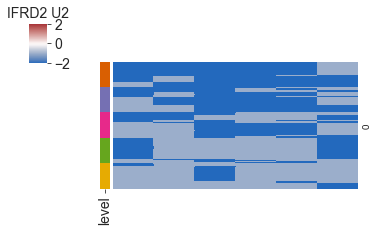

In [54]:
gene_name = "IFRD2"
replicate = "U2"

sns.clustermap(IFRD2_U2_mat1_bis, col_cluster=False, row_cluster=False, 
               cmap="vlag", yticklabels=False, xticklabels=False, figsize=(5,3),
              row_colors=IFRD2_U2_colors1, vmin=-2, vmax=2)

plt.title(gene_name + ' ' + replicate, fontsize=14)

plt.savefig("/path/to/plots/FigS8_IFRD2_U2_heatmap_PCR_subsampled.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.show()